# Code for launching White-box evasion attack on NN for the Mnist Dataset

## Generating the model

### Imports

In [149]:
import tensorflow as tf
import tensorflow_datasets as tfds
import datetime
import numpy as np
import seaborn as sns
import matplotlib.pylab as plt
from collections import defaultdict
import scipy as sp

In [2]:
%load_ext tensorboard

### 1. Create input pipeline

#### Load dataset

In [70]:
(ds_train, ds_test), ds_info = tfds.load(
    'mnist',
    split=['train', 'test'],
    shuffle_files=True,
    as_supervised=True,
    with_info=True,
)

In [72]:
ds_info

tfds.core.DatasetInfo(
    name='mnist',
    full_name='mnist/3.0.1',
    description="""
    The MNIST database of handwritten digits.
    """,
    homepage='http://yann.lecun.com/exdb/mnist/',
    data_path='/Users/danieldelijani/tensorflow_datasets/mnist/3.0.1',
    download_size=11.06 MiB,
    dataset_size=21.00 MiB,
    features=FeaturesDict({
        'image': Image(shape=(28, 28, 1), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=10),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'test': <SplitInfo num_examples=10000, num_shards=1>,
        'train': <SplitInfo num_examples=60000, num_shards=1>,
    },
    citation="""@article{lecun2010mnist,
      title={MNIST handwritten digit database},
      author={LeCun, Yann and Cortes, Corinna and Burges, CJ},
      journal={ATT Labs [Online]. Available: http://yann.lecun.com/exdb/mnist},
      volume={2},
      year={2010}
    }""",
)

#### Build a training pipeline

In [4]:
def normalize_img(image, label):
  """Normalizes images: `uint8` -> `float32`."""
  return tf.cast(image, tf.float32) / 255., label

ds_train = ds_train.map(
    normalize_img, num_parallel_calls=tf.data.AUTOTUNE)
ds_train = ds_train.cache()
ds_train = ds_train.shuffle(ds_info.splits['train'].num_examples)
ds_train = ds_train.batch(128)
ds_train = ds_train.prefetch(tf.data.AUTOTUNE)

#### Build an evaluation pipeline

In [5]:
ds_test = ds_test.map(
    normalize_img, num_parallel_calls=tf.data.AUTOTUNE)
ds_test = ds_test.batch(128)
ds_test = ds_test.cache()
ds_test = ds_test.prefetch(tf.data.AUTOTUNE)

### 2. Create and train the model

In [6]:
# mnist = tf.keras.datasets.mnist

# (x_train, y_train),(x_test, y_test) = mnist.load_data()
# x_train, x_test = x_train / 255.0, x_test / 255.0

# def create_model():
#     return tf.keras.models.Sequential([
#     tf.keras.layers.Flatten(input_shape=(28, 28)),
#     tf.keras.layers.Dense(512, activation='relu'),
#     tf.keras.layers.Dropout(0.2),
#     tf.keras.layers.Dense(10, activation='softmax')
#   ])

# model = create_model()
# model.compile(optimizer='adam',
#               loss='sparse_categorical_crossentropy',
#               metrics=['accuracy'])

# log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
# tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

# model.fit(x=x_train, 
#           y=y_train, 
#           epochs=5, 
#           validation_data=(x_test, y_test), 
#           callbacks=[tensorboard_callback])

In [7]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=(28, 28)),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(10)
])
model.compile(
    optimizer=tf.keras.optimizers.Adam(0.001),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy()],
)

log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

model.fit(
    ds_train,
    epochs=6,
    validation_data=ds_test,
    callbacks=[tensorboard_callback]
)

Epoch 1/6
469/469 [==============================] - 10s 8ms/step - loss: 0.3685 - sparse_categorical_accuracy: 0.8997 - val_loss: 0.1970 - val_sparse_categorical_accuracy: 0.9443
Epoch 2/6
469/469 [==============================] - 3s 5ms/step - loss: 0.1694 - sparse_categorical_accuracy: 0.9520 - val_loss: 0.1428 - val_sparse_categorical_accuracy: 0.9593
Epoch 3/6
469/469 [==============================] - 2s 5ms/step - loss: 0.1219 - sparse_categorical_accuracy: 0.9652 - val_loss: 0.1108 - val_sparse_categorical_accuracy: 0.9665
Epoch 4/6
469/469 [==============================] - 2s 5ms/step - loss: 0.0941 - sparse_categorical_accuracy: 0.9729 - val_loss: 0.0994 - val_sparse_categorical_accuracy: 0.9715
Epoch 5/6
469/469 [==============================] - 8s 16ms/step - loss: 0.0753 - sparse_categorical_accuracy: 0.9779 - val_loss: 0.0882 - val_sparse_categorical_accuracy: 0.9737
Epoch 6/6
469/469 [==============================] - 7s 15ms/step - loss: 0.0628 - sparse_categorical_a

In [8]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 128)               100480    
                                                                 
 dense_1 (Dense)             (None, 10)                1290      
                                                                 
Total params: 101,770
Trainable params: 101,770
Non-trainable params: 0
_________________________________________________________________


In [9]:
type(model.layers[1])

keras.layers.core.dense.Dense

In [10]:
model.layers[i].bias

NameError: name 'i' is not defined

## Exploring the model

### What input nodes have the most impact?

In [11]:
i = 1
layer = model.layers[i]
weights = model.layers[i].weights[0]
bias = model.layers[i].weights[1]
print(layer.name, layer)
print('weights:', weights)
print('bias:', bias)

dense <keras.layers.core.dense.Dense object at 0x7ff1689c5890>
weights: <tf.Variable 'dense/kernel:0' shape=(784, 128) dtype=float32, numpy=
array([[ 1.26797706e-03,  3.46396491e-02, -4.56183739e-02, ...,
        -1.08852386e-02,  8.07885751e-02, -8.99872929e-03],
       [-1.05465204e-03, -3.05284634e-02,  2.19174474e-03, ...,
         4.05607522e-02,  1.15009919e-02,  6.38263151e-02],
       [ 6.74769953e-02,  3.66456881e-02,  4.15829122e-02, ...,
         5.67957759e-05, -2.99095623e-02, -3.97775695e-02],
       ...,
       [ 7.25986585e-02, -4.69111763e-02,  1.24897957e-02, ...,
         5.77621162e-03, -5.96824586e-02,  7.03370199e-02],
       [ 3.47066596e-02, -7.37524256e-02,  3.91883478e-02, ...,
         6.93554357e-02, -1.05005205e-02,  6.87776133e-02],
       [-3.97101156e-02,  9.59676504e-03,  6.35042712e-02, ...,
         3.01511958e-02,  6.46227971e-02, -6.99427277e-02]], dtype=float32)>
bias: <tf.Variable 'dense/bias:0' shape=(128,) dtype=float32, numpy=
array([-6.6720023

In [12]:
sum_of_weights = weights.numpy().sum(axis=1)
sum_of_weights.shape

(784,)

In [13]:
reshaped_weights = np.reshape(sum_of_weights, (28, 28))

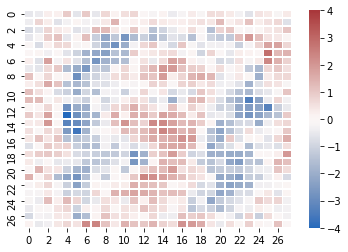

In [14]:
ax = sns.heatmap(reshaped_weights, linewidth=.5, cmap='vlag',vmin = -4, vmax=4)
plt.show()

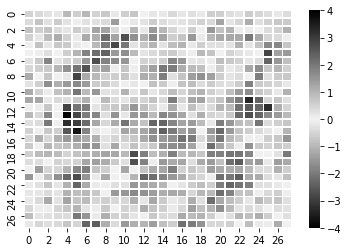

In [15]:
ax = sns.heatmap(reshaped_weights, linewidth=.5, cmap=sns.diverging_palette(0, 0, l=0, as_cmap=True),vmin = -4, vmax=4)
plt.show()

### Get average of each pixel

In [97]:
overall_image = np.zeros((28, 28, 1))
for image in tfds.as_numpy(ds_train):
    im = image[0]
    overall_image = np.add(overall_image, im)
overall_image

array([[[0.000000e+00],
        [0.000000e+00],
        [0.000000e+00],
        [0.000000e+00],
        [0.000000e+00],
        [0.000000e+00],
        [0.000000e+00],
        [0.000000e+00],
        [0.000000e+00],
        [0.000000e+00],
        [0.000000e+00],
        [0.000000e+00],
        [1.260000e+02],
        [4.700000e+02],
        [2.160000e+02],
        [9.000000e+00],
        [0.000000e+00],
        [0.000000e+00],
        [0.000000e+00],
        [0.000000e+00],
        [0.000000e+00],
        [0.000000e+00],
        [0.000000e+00],
        [0.000000e+00],
        [0.000000e+00],
        [0.000000e+00],
        [0.000000e+00],
        [0.000000e+00]],

       [[0.000000e+00],
        [0.000000e+00],
        [0.000000e+00],
        [0.000000e+00],
        [1.600000e+01],
        [5.500000e+01],
        [5.570000e+02],
        [1.457000e+03],
        [2.623000e+03],
        [3.846000e+03],
        [7.208000e+03],
        [9.644000e+03],
        [1.045100e+04],
        [1.064

In [98]:
print(overall_image.shape)
overall_image = np.squeeze(overall_image)
print(overall_image.shape)

(28, 28, 1)
(28, 28)


#### Visualization

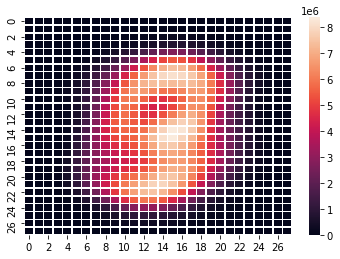

In [148]:
ax = sns.heatmap(overall_image, linewidth=.5)
plt.show()

#### Correlation

In [157]:
correlation, p_value = sp.stats.pearsonr(overall_image.flatten(), reshaped_weights.flatten())
print(f"correlation = {correlation}\np_value = {p_value}")

correlation = 0.2620847623688074
p_value = 8.824503438241546e-14


### Get standard deviation of each pixel
for each pixel, average for 1 is ___
                average for 2 is ___
                ...
                get the standard deviation for that pixel
                plot that on heatmap


In [105]:
average_image_hashmap = {}

for datapoint in tfds.as_numpy(ds_train):
    image = datapoint[0]
    label = datapoint[1]
    if label in average_image_hashmap:
        average_image_hashmap[label] = np.add(average_image_hashmap[label], image)
    else:
        average_image_hashmap[label] = image


In [108]:
np.squeeze(average_image_hashmap[0]).shape

(28, 28)

#### Visualize averages for each number individually

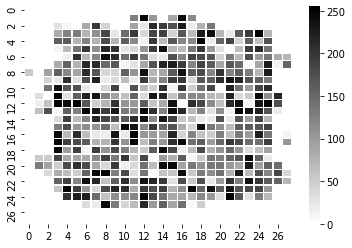

In [112]:
ax = sns.heatmap(np.squeeze(average_image_hashmap[0]), linewidth=.5, cmap='binary')
plt.show()

#### Get the standard deviation for each pixel

In [131]:
overall_averages = np.array(list(average_image_hashmap.values())).squeeze()
overall_averages.shape

(10, 28, 28)

In [143]:
standard_deviations = np.std(overall_averages, axis=0)
standard_deviations.shape

(28, 28)

#### Visualization

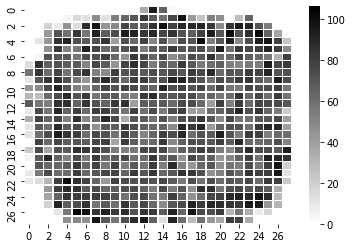

In [146]:
ax = sns.heatmap(standard_deviations, linewidth=.5, cmap='binary')
plt.show()

#### Correlation

In [159]:
correlation, p_value = sp.stats.pearsonr(standard_deviations.flatten(), reshaped_weights.flatten())
print(f"correlation = {correlation}\np_value = {p_value}")

correlation = -0.06247435016342633
p_value = 0.0804296309405518


### Entropy

In [ ]:
pixel_0 = []

In [171]:
for x in tfds.as_numpy(ds_train): 
    print(x[0][0][0].item())
    break

0


In [172]:
pixel_0 = [x[0][0][0].item() for x in tfds.as_numpy(ds_train)]

In [174]:
from collections import Counter

counts = Counter(pixel_0)


In [176]:
test = {1: 2, 3: 4}

In [179]:
list(Counter(test).values())

TypeError: unsupported operand type(s) for /: 'list' and 'int'

In [175]:
counts.values()

dict_values([60000])

In [161]:
sp.stats.entropy

<function scipy.stats._distn_infrastructure.entropy(pk, qk=None, base=None, axis=0)>

# For Later

In [17]:
%tensorboard --logdir logs